### DCGAN Architecture

* These are one of the successful GANs as it makes use of convolutional layers
* Downsampling and upsampling is performed by convolutional stride and transposed convolution
* It doesn't make use of fully conected layers
* The trained discriminators are used for image classification tasks, showing competitive performance with other unsupervised algorithms

The DCGAN architecture can be shown as below
<img src="../../images/dcgan.png" alt="drawing" width="700"/>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dset
#from utils import get_celeba
#from dcgan import weights_init, Generator, Discriminator

In [2]:
# Set random seed for reproducibility.
seed = 369
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Parameters to define the model.
params = {
    "bsize" : 128,# Batch size during training.
    'imsize' : 64,# Spatial size of training images. All images will be resized to this size during preprocessing.
    'nc' : 3,# Number of channles in the training images. For coloured images this is 3.
    'nz' : 100,# Size of the Z latent vector (the input to the generator).
    'ngf' : 64,# Size of feature maps in the generator. The depth will be multiples of this.
    'ndf' : 64, # Size of features maps in the discriminator. The depth will be multiples of this.
    'nepochs' : 10,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'save_epoch' : 2}# Save step.

Random Seed:  369


In [3]:
# Use GPU is available else use CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cuda:0  will be used.



In [7]:
root = '../data/celeba'

def get_celeba(params):
    """
    Loads the dataset and applies proproccesing steps to it.
    Returns a PyTorch DataLoader.

    """
    # Data proprecessing.
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    # Create the dataset.
    dataset = dset.ImageFolder(root=root, transform=transform)

    # Create the dataloader.
    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True)

    return dataloader

In [8]:
# Get the data.
dataloader = get_celeba(params)

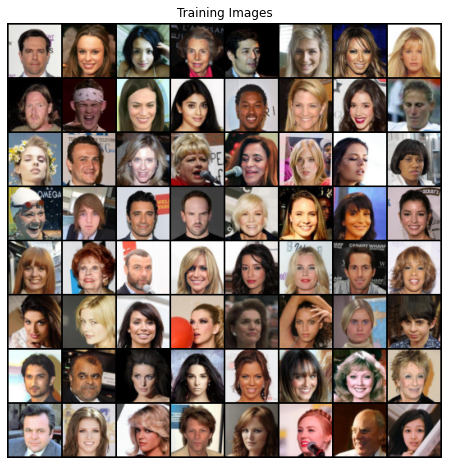

In [9]:
# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

In [20]:
def weights_init(w):
    """
    Initializes the weights of the layer, w.
    """
    classname = w.__class__.__name__
    
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [21]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        # Input is the latent vector Z.
        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8)

        # Input Dimension: (ngf*8) x 4 x 4
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8, params['ngf']*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4)

        # Input Dimension: (ngf*4) x 8 x 8
        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4, params['ngf']*2,4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2)

        # Input Dimension: (ngf*2) x 16 x 16
        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf'])

        # Input Dimension: (ngf) * 32 * 32
        self.tconv5 = nn.ConvTranspose2d(params['ngf'], params['nc'],4, 2, 1, bias=False)
        #Output Dimension: (nc) x 64 x 64

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))

        x = F.tanh(self.tconv5(x))

        return x

In [22]:
# Create the generator.
netG = Generator(params).to(device)
# Apply the weights_init() function to randomly initialize all
# weights to mean=0.0, stddev=0.2
netG.apply(weights_init)
# Print the model.
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


In [23]:
# Define the Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        # Input Dimension: (nc) x 64 x 64
        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        # Input Dimension: (ndf) x 32 x 32
        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        # Input Dimension: (ndf*2) x 16 x 16
        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        # Input Dimension: (ndf*4) x 8 x 8
        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        # Input Dimension: (ndf*8) x 4 x 4
        self.conv5 = nn.Conv2d(params['ndf']*8, 1, 4, 1, 0, bias=False)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)

        x = F.sigmoid(self.conv5(x))

        return x

In [24]:
# Create the discriminator.
netD = Discriminator(params).to(device)
# Apply the weights_init() function to randomly initialize all
# weights to mean=0.0, stddev=0.2
netD.apply(weights_init)
# Print the model.
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [31]:
# Binary Cross Entropy loss function.
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1.0
fake_label = 0.0

# Optimizer for the discriminator.
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
# Optimizer for the generator.
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

# Stores generated images as training progresses.
img_list = []
# Stores generator losses during training.
G_losses = []
# Stores discriminator losses during training.
D_losses = []

iters = 0

print("Starting Training Loop...")
print("-"*25)

Starting Training Loop...
-------------------------


In [40]:
for epoch in range(params['nepochs']):
    for i, data in enumerate(dataloader, 0):
        
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        ### Train discriminator max log((D(x))) + lo(1-D(G(z)))
        disc_real = netD(real_data).view(-1) #N
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = netD(fixed_noise).view(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_real))
        loss_disc = (loss_disc_real + loss_disc_fake)/2
        netD.zero_grad()
        loss_disc.backward(retain_graph=True)
        optimizerD.step()
        
        ### Train Generator min log(1-D(G(z))) <-> max log(D(G(z)))
        output = netD(fake).view(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        netG.zero_grad()
        loss_gen.backward()
        optimizerG.step()
        

        
#         # discriminator output with real data and real label
#         netD.zero_grad()
#         label = torch.full((b_size, ), real_label, device=device)
#         output = netD(real_data).view(-1)
#         errD_real = criterion(output, label)
#         errD_real.backward()
#         D_x = output.mean().item()
        
        
#         noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
#         fake_data = netG(noise)
        
#         label.fill_(fake_label  )
        
#         # Calculate the output of the discriminator of the fake data.
#         # As no gradients w.r.t. the generator parameters are to be
#         # calculated, detach() is used. Hence, only gradients w.r.t. the
#         # discriminator parameters will be calculated.
#         # This is done because the loss functions for the discriminator
#         # and the generator are slightly different.
#         output = netD(fake_data.detach()).view(-1)
#         errD_fake = criterion(output, label)
#         # Calculate gradients for backpropagation.
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()

#         # Net discriminator loss.
#         errD = errD_real + errD_fake
#         # Update discriminator parameters.
#         optimizerD.step()
        
        
        
#         # Make accumalted gradients of the generator zero.
#         netG.zero_grad()
#         # We want the fake data to be classified as real. Hence
#         # real_label are used. (label=1)
#         label.fill_(real_label)
#         # No detach() is used here as we want to calculate the gradients w.r.t.
#         # the generator this time.
#         output = netD(fake_data).view(-1)
#         errG = criterion(output, label)
#         # Gradients for backpropagation are calculated.
#         # Gradients w.r.t. both the generator and the discriminator
#         # parameters are calculated, however, the generator's optimizer
#         # will only update the parameters of the generator. The discriminator
#         # gradients will be set to zero in the next iteration by netD.zero_grad()
#         errG.backward()

#         D_G_z2 = output.mean().item()
#         # Update generator parameters.
#         optimizerG.step()

        # Check progress of training.
        if i%50 == 0:
            print(torch.cuda.is_available())
            print('[%d/%d][%d/%d]\tLoss_G: %.4f\tLoss_D: %.4f'
                  % (epoch, params['nepochs'], i, len(dataloader),
                     loss_gen, loss_disc))

        # Save the losses for plotting.
        G_losses.append(loss_gen.item())
        D_losses.append(loss_disc.item())

        # Check how the generator is doing by saving G's output on a fixed noise.
        if (iters % 100 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    # Save the model.
    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_epoch_{}.pth'.format(epoch))

RuntimeError: Given groups=1, weight of size [64, 3, 4, 4], expected input[64, 100, 1, 1] to have 3 channels, but got 100 channels instead

In [ ]:
# Save the final trained model.
torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/model_final.pth')

In [ ]:
# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [ ]:
# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
plt.show()
anim.save('celeba.gif', dpi=80, writer='imagemagick')